In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl 
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [3]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/ssl/.fastai/data/mnist.pkl.gz')

In [4]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [5]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n,c = x_train.shape

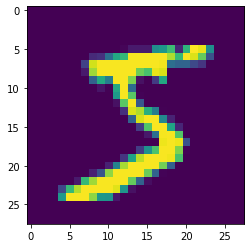

In [6]:
img = x_train[0]
plt.imshow(img.view(28,28))

In [7]:
img.view(28,28).type()

'torch.FloatTensor'

Initial python model

In [8]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [9]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c=torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k]*b[k,j]
    return c

In [10]:
m1 = x_valid[:5]
m2 = weights

In [11]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [12]:
%time t1=matmul(m1,m2)

CPU times: user 826 ms, sys: 4.07 ms, total: 830 ms
Wall time: 829 ms


In [13]:
t1.shape

torch.Size([5, 10])

In [14]:
len(x_train)

50000

Speeding up the computation

In [15]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c=torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c

In [16]:
%time t1=matmul(m1,m2)

CPU times: user 1.45 ms, sys: 186 µs, total: 1.63 ms
Wall time: 1.39 ms


In [17]:
a = tensor([10,20,30])

In [18]:
m = tensor([[1,2,3],
           [4,5,6],
           [7,8,9]])

In [19]:
a[:, None] + m

tensor([[11, 12, 13],
        [24, 25, 26],
        [37, 38, 39]])

In [20]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c=torch.zeros(ar,bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1)*b).sum(dim=0)
    return c

In [21]:
%timeit -n 10 _=matmul(m1,m2)

248 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit -n 10 _=m1.matmul(m2)

The slowest run took 4.59 times longer than the fastest. This could mean that an intermediate result is being cached.
8.96 µs ± 6.46 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
def normalize(x, m, s): return (x-m)/s

In [24]:
train_mean, train_std = x_train.mean(), x_train.std()

Why mean and std should be 0 and 1 respectively?

In [25]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [26]:
x_train.mean(), x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [27]:
n,m = x_train.shape
c = y_train.max() + 1
n,m,c

(50000, 784, tensor(10))

## Creating the model

In [28]:
nh=50 #Hidden network

What was the reason to select number of hidden units as 50?

In [29]:
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [30]:
w1.mean(), w1.std()

(tensor(-0.0001), tensor(0.0355))

In [31]:
w2.mean(), w2.std()

(tensor(-0.0145), tensor(0.1313))

In [32]:
def lin(x, w, b): return x@w + b

In [33]:
t = lin(x_valid, w1, b1)

In [34]:
t.mean(), t.std()

(tensor(-0.1027), tensor(0.9925))

In [35]:
def relu(x): return x.clamp_min(0.)

In [36]:
t = relu(lin(x_valid, w1, b1)) - 0.5

In [37]:
t.mean(), t.std()

(tensor(-0.1573), tensor(0.5497))

In [38]:
w1 = torch.randn(m,nh)*math.sqrt(2/m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)*math.sqrt(2/nh)
b2 = torch.zeros(1)

In [39]:
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.6138), tensor(0.8583))

Let's do a forward pass

In [40]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [41]:
%timeit -n 10 _=model(x_valid)

4.31 ms ± 453 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now let's find a loss function

In [42]:
model(x_valid).shape

torch.Size([10000, 1])

In [43]:
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [44]:
y_train, y_valid = y_train.float(), y_valid.float()

In [45]:
preds = model(x_train)

In [46]:
preds.shape

torch.Size([50000, 1])

In [47]:
mse(preds, y_train)

tensor(24.3063)

Gradients and Backward propogation

In [48]:
def mse_grad(inp, targ):
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [49]:
def relu_grad(inp, out):
    inp.g = (inp>0).float() * out.g

In [50]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [51]:
def forward_and_backward(inp, targ):
    # Forward pass
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    loss = mse(out, targ)
    
    # Backward pass
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [52]:
forward_and_backward(x_train, y_train)

In [53]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig = x_train.g.clone()

In [54]:
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)
xt2 = x_train.clone().requires_grad_(True)

In [55]:
def forward(inp, targ):
    # Forward pass
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    return mse(out, targ) 

In [56]:
loss = forward(xt2, y_train)

In [57]:
loss.backward()

In [58]:
w12.grad, w1.g

(tensor([[ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         ...,
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446]]),
 tensor([[ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         ...,
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446]]))

## Refactoring

Writing layers as classes

In [59]:
class ReLU():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [60]:
class Lin():
    def __init__(self, w, b): self.w, self.b = w,b
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [61]:
class Mse:
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [62]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), ReLU(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [63]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [64]:
%time loss = model(x_train, y_train)

CPU times: user 152 ms, sys: 12.8 ms, total: 165 ms
Wall time: 31.7 ms


In [65]:
%time model.backward()

CPU times: user 5.02 s, sys: 2.45 s, total: 7.47 s
Wall time: 1.9 s


In [66]:
w1.g, w1g

(tensor([[ 1.1502, -0.0757,  0.3895,  ...,  0.7737,  0.0048,  0.4834],
         [ 1.1502, -0.0757,  0.3895,  ...,  0.7737,  0.0048,  0.4834],
         [ 1.1502, -0.0757,  0.3895,  ...,  0.7737,  0.0048,  0.4834],
         ...,
         [ 1.1502, -0.0757,  0.3895,  ...,  0.7737,  0.0048,  0.4834],
         [ 1.1502, -0.0757,  0.3895,  ...,  0.7737,  0.0048,  0.4834],
         [ 1.1502, -0.0757,  0.3895,  ...,  0.7737,  0.0048,  0.4834]]),
 tensor([[ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         ...,
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446],
         [ 1.0632, -0.0690,  0.3587,  ...,  0.7137,  0.0044,  0.4446]]))

## Module forward

In [67]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('Not Implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [68]:
class ReLU(Module):
    def forward(self, inp): return inp.clamp_min(0.) - 0.5    
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [69]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [70]:
class Mse(Module):
    def forward(self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
        
    def bwd(self, out, inp, targ): inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / targ.shape[0]

In [71]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), ReLU(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [72]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [73]:
%time loss = model(x_train, y_train)

CPU times: user 81.2 ms, sys: 5.86 ms, total: 87 ms
Wall time: 21.5 ms


In [74]:
%time model.backward()

CPU times: user 180 ms, sys: 54.4 ms, total: 234 ms
Wall time: 58.3 ms


In [75]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [76]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [77]:
%time loss = model(x_train, y_train)

CPU times: user 101 ms, sys: 17.5 ms, total: 118 ms
Wall time: 29.4 ms


In [78]:
%time model.backward()

CPU times: user 177 ms, sys: 53.7 ms, total: 231 ms
Wall time: 57.5 ms


## Implementing using PyTorch

In [79]:
from torch import nn

In [80]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x # self.loss(x.squeeze().float(), targ.float())

In [81]:
model = Model(m, nh, 1)

In [82]:
%time loss = model(x_train, y_train)

TypeError: __call__() takes 2 positional arguments but 3 were given

In [83]:
%time loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# Lec 9 begins from here

In [84]:
l1 = nn.Conv2d(1, nh, 5)

In [85]:
x = x_valid[:100]
x.shape

torch.Size([100, 784])

In [86]:
l1.weight.mean(), l1.weight.std()

(tensor(-0.0003, grad_fn=<MeanBackward0>),
 tensor(0.1156, grad_fn=<StdBackward0>))

In [87]:
def stats(x): return x.mean(), x.std()

In [88]:
stats(l1.weight), stats(l1.bias)

((tensor(-0.0003, grad_fn=<MeanBackward0>),
  tensor(0.1156, grad_fn=<StdBackward0>)),
 (tensor(-0.0006, grad_fn=<MeanBackward0>),
  tensor(0.1130, grad_fn=<StdBackward0>)))

In [89]:
nn.modules.conv??

In [90]:
from torch.nn import init

In [91]:
init.kaiming_normal_(l1.weight, a=1.)

Parameter containing:
tensor([[[[ 0.2420,  0.2503,  0.0211, -0.0200, -0.1312],
          [ 0.0245,  0.0533, -0.3607, -0.1565,  0.2103],
          [ 0.1265, -0.1416,  0.0575, -0.0163,  0.0886],
          [-0.1485, -0.3231,  0.0939,  0.0231,  0.1901],
          [-0.0593, -0.0679,  0.0377,  0.0311, -0.1450]]],


        [[[ 0.0429, -0.3494,  0.1499,  0.0929, -0.1209],
          [ 0.1856,  0.2776, -0.0111,  0.2156, -0.3477],
          [-0.2433, -0.3081, -0.2735,  0.1366,  0.0970],
          [-0.4858, -0.1862, -0.1674,  0.0606, -0.0481],
          [-0.3028,  0.1749, -0.1607, -0.2291, -0.2883]]],


        [[[ 0.1760,  0.0527,  0.3034,  0.1388,  0.0454],
          [ 0.0909, -0.0626,  0.1673, -0.2723,  0.1457],
          [-0.1469, -0.3661, -0.2363,  0.1017, -0.0346],
          [ 0.0863, -0.0642,  0.0222, -0.1394,  0.3011],
          [ 0.1926,  0.2031,  0.0809, -0.1867, -0.1921]]],


        ...,


        [[[-0.0915, -0.0550, -0.0304, -0.5906, -0.2486],
          [-0.0747,  0.1807, -0.0579, -

In [92]:
stats(l1.weight)

(tensor(-0.0052, grad_fn=<MeanBackward0>),
 tensor(0.2015, grad_fn=<StdBackward0>))

In [93]:
init.kaiming_normal_(l1.weight, a=1)
stats(l1.weight)

(tensor(-0.0031, grad_fn=<MeanBackward0>),
 tensor(0.2036, grad_fn=<StdBackward0>))

In [94]:
l1.weight.shape

torch.Size([50, 1, 5, 5])

In [95]:
rec_fs = l1.weight[0,0].numel()
rec_fs

25

In [96]:
nf, ni, *_ = l1.weight.shape
nf, ni

(50, 1)

In [97]:
fan_in = ni*rec_fs
fan_out = nf*rec_fs
fan_in, fan_out

(25, 1250)

In [98]:
def gain(a): return math.sqrt(2.0 / (1 + a ** 2))

In [99]:
gain(1), gain(0), gain(0.01), gain(0.1), gain(math.sqrt(5.))

(1.0,
 1.4142135623730951,
 1.4141428569978354,
 1.4071950894605838,
 0.5773502691896257)

In [100]:
model = Model(m, nh, 10)

In [101]:
pred = model(x_train)

### Cross Entropy Loss

In [102]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [103]:
sm_pred = log_softmax(pred)

In [104]:
y_train[:3]

tensor([5., 0., 4.])

In [105]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.8406, -2.2103, -2.1020], grad_fn=<IndexBackward>)

In [106]:
y_train.shape[0]

50000

In [107]:
y_train.type()

'torch.FloatTensor'

In [108]:
def nll(input, target): return -input[range(target.shape[0]), target.long()].mean()

In [109]:
loss = nll(sm_pred, y_train)

In [110]:
loss

tensor(2.2621, grad_fn=<NegBackward>)

In [111]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [112]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [113]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

### Basic training loop

In [114]:
import torch.nn.functional as F

In [115]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [116]:
loss_func = F.cross_entropy
bs=64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.1634,  0.0692, -0.0268,  0.1276,  0.1130, -0.5341,  0.0367,  0.3491,
         -0.1697,  0.0038], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [117]:
yb = y_train[0:bs]
loss_func(preds, yb.long())

tensor(2.2364, grad_fn=<NllLossBackward>)

In [118]:
accuracy(preds, yb)

tensor(0.1719)

In [119]:
lr = 0.5
epochs = 1

In [120]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i + bs
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb.long())
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [121]:
loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())

(tensor(0.4167, grad_fn=<NllLossBackward>), tensor(0.8750))

### Using parameters and optim

In [122]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [123]:
model = Model(m, nh, 10)

In [124]:
model.named_children

<bound method Module.named_children of Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)>

In [125]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs+1):
            start_i = i*bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb.long())

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [126]:
fit()
loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())

(tensor(0.1897, grad_fn=<NllLossBackward>), tensor(0.9375))

In [127]:
# nn.Sequential??

In [128]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [129]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [130]:
opt = Optimizer(model.parameters())

In [131]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs+1):
            start_i = i*bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb.long())

            loss.backward()
            opt.step()
            opt.zero_grad()

In [132]:
fit()
loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())

(tensor(0.6357, grad_fn=<NllLossBackward>), tensor(0.8125))

In [133]:
from torch import optim

In [134]:
optim.SGD.step??

In [135]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [136]:
model, opt = get_model()
loss_func(model(xb), yb.long())

tensor(2.3014, grad_fn=<NllLossBackward>)

In [137]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs+1):
            start_i = i*bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb.long())

            loss.backward()
            opt.step()
            opt.zero_grad()
            
fit()
loss, acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())
loss, acc

(tensor(0.5018, grad_fn=<NllLossBackward>), tensor(0.8750))

In [138]:
assert acc > 0.7

## Datasets an DataLoader

### Dataset

In [139]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [140]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [141]:
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb, yb

(tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]]),
 tensor([5., 0., 4., 1., 9.]))

In [142]:
model, opt = get_model()

In [143]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i + bs

        xb, yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()

In [144]:
loss, acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())
assert acc>0.7
loss, acc

(tensor(0.2850, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

In [145]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [146]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [147]:
xb, yb = next(iter(valid_dl))
assert xb.shape==(bs, 28*28)
assert yb.shape==(bs, )

tensor(3.)

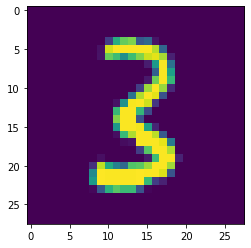

In [148]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [149]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb.long())

            loss.backward()
            opt.step()
            opt.zero_grad()
            
fit()
loss, acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())
loss, acc

(tensor(0.4500, grad_fn=<NllLossBackward>), tensor(0.9062))

## Random Sampling

In [150]:
class Sampler:
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds),bs,shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [151]:
small_ds = Dataset(*train_ds[:10])

In [152]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [153]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([1, 3, 7]), tensor([0, 6, 2]), tensor([8, 9, 4]), tensor([5])]

In [154]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [155]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [156]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3.)

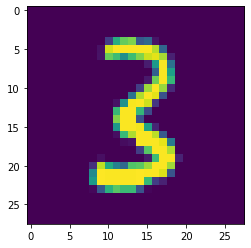

In [157]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(0.)

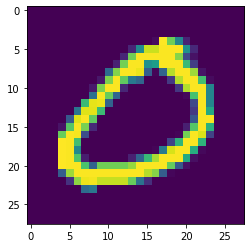

In [158]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [159]:
model , opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())
assert acc>0.7
loss, acc

(tensor(0.3041, grad_fn=<NllLossBackward>), tensor(0.9219))

### PyTorch DataLoader

In [160]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [161]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [162]:
model , opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb.long())
assert acc>0.7
loss, acc

(tensor(0.4102, grad_fn=<NllLossBackward>), tensor(0.8438))

### Validation

In [163]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb.long())

            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb.long())
                tot_acc += accuracy(pred, yb.long())
                
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv,tot_acc/nv

In [164]:
fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(1.0938) tensor(0.8283)
1 tensor(0.4576) tensor(0.8949)
2 tensor(0.4269) tensor(0.8730)
3 tensor(0.2561) tensor(0.9355)
4 tensor(0.3563) tensor(0.9206)


(tensor(0.3563), tensor(0.9206))

In [165]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return(DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
           DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [166]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.3760) tensor(0.9076)
1 tensor(0.6093) tensor(0.8739)
2 tensor(0.2139) tensor(0.9423)
3 tensor(0.2168) tensor(0.9422)
4 tensor(0.2220) tensor(0.9399)


## DataBunch and Learner

In [167]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh,bs = 50,64
c = int(y_train.max().item()+1)
loss_func = F.cross_entropy

In [168]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [169]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [170]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

In [171]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [172]:
learn = Learner(*get_model(data), loss_func, data)

In [173]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            pred = learn.model(xb)
            loss = learn.loss_func(pred, yb.long())

            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            
        learn.model.eval()
        
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb.long())
                tot_acc += accuracy(pred, yb.long())
                
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv,tot_acc/nv

In [174]:
loss, acc = fit(1, learn)

0 tensor(1.1285) tensor(0.7803)


## Callback Handler

In [175]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [176]:
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0
        self.run.n_iter=0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False

In [177]:
class TestCallback(Callback):
    def after_step(self):
        if self.train_eval.n_iters>=10: return True

In [178]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [179]:
TrainEvalCallback().name

'train_eval'

In [180]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [181]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+cbs
    
    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self): return self.learn.data
    
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb.long())
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()
        
    def all_batches(self, dl):
        self.iters = len(dl)
        for xb, yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop = False
        
    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
        
        try: 
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
        
        finally:
            self('after_fit')
            self.learn = None
            
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [182]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics, self.in_train = listify(metrics), in_train
    
    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ''
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
        
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn
    
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [183]:
learn = Learner(*get_model(data), loss_func, data)

In [184]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [185]:
run.fit(2, learn)

train: [0.5143828125, tensor(0.8507)]
valid: [0.32987255859375, tensor(0.9076)]
train: [0.26448880859375, tensor(0.9267)]
valid: [0.26346669921875, tensor(0.9301)]


In [186]:
loss,acc = stats.valid_stats.avg_stats
assert acc>0.9
loss,acc

(0.26346669921875, tensor(0.9301))

In [189]:
from functools import partial

In [190]:
acc_cbf = partial(AvgStatsCallback, accuracy)

In [191]:
run = Runner(cb_funcs=acc_cbf)

In [192]:
run.fit(1, learn)

train: [0.22152916015625, tensor(0.9382)]
valid: [0.1876039306640625, tensor(0.9479)]


In [193]:
run.avg_stats.valid_stats.avg_stats

[0.1876039306640625, tensor(0.9479)]